In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL
import torch
from torch import nn
import numpy as np
import os 

In [2]:
DATA_PATH = 'clean'
DATA_PATH_X = 'clean/x-data'
DATA_PATH_Y = 'clean/y-data'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 4
IMG_SIZE = (128)

In [23]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        name = f"{idx}.png"
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        label_path = os.path.join(self.label_dir, os.listdir(self.label_dir)[idx])
        image = read_image(img_path)
        label = read_image(label_path)
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

In [24]:
class MyTransform:
    def __init__(self, img_size):
        self.img_size = (img_size, img_size)

    def __call__(self, x):
        resized_img = transforms.Resize(size=self.img_size)(x)
        pil_img =transforms.ToPILImage()(resized_img)
        gray_img = transforms.functional.to_grayscale(pil_img, num_output_channels=1)
        return transforms.ToTensor()(gray_img) 

In [25]:
dset = CustomImageDataset(DATA_PATH_X, DATA_PATH_Y, transform=MyTransform(IMG_SIZE))
dls =  torch.utils.data.DataLoader(dset, batch_size=BATCH_SIZE)

In [26]:
for X, y in dls:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([4, 1, 128, 128])
Shape of y: torch.Size([4, 1, 128, 128]) torch.float32


## Model

In [27]:
class LSNet(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super(LSNet, self).__init__()
        self.conv_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.deconv_part = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(size=IMG_SIZE, mode='bilinear'),
        )
    def forward(self, x):
        x = self.conv_part(x)
        x = self.deconv_part(x)
        return x

In [28]:
model = LSNet()

In [29]:
input_test = torch.rand(20, 1, IMG_SIZE, IMG_SIZE)
print(input_test.shape)
model(input_test).shape

torch.Size([20, 1, 128, 128])


torch.Size([20, 1, 128, 128])

In [30]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [32]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dls, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.454311  [    0/  858]
loss: 0.038451  [  400/  858]
loss: 0.026869  [  800/  858]
Epoch 2
-------------------------------
loss: 0.073936  [    0/  858]
loss: 0.025417  [  400/  858]
loss: 0.025735  [  800/  858]
Epoch 3
-------------------------------
loss: 0.059718  [    0/  858]
loss: 0.021228  [  400/  858]
loss: 0.021297  [  800/  858]
Epoch 4
-------------------------------
loss: 0.053381  [    0/  858]
loss: 0.017154  [  400/  858]
loss: 0.023573  [  800/  858]
Epoch 5
-------------------------------
loss: 0.053134  [    0/  858]
loss: 0.015619  [  400/  858]
loss: 0.022245  [  800/  858]
Done!


In [33]:
torch.save(model.state_dict(), "models/main/model_2022_07_21_15_51.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [62]:
model.eval()
x, y = dset[20][0], dset[20][1]
print(x.shape)
print(y.shape)
with torch.no_grad():
    pred = model(x[None,:])


torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


In [63]:
new_pred = pred[0]
new_pred.shape

torch.Size([1, 128, 128])

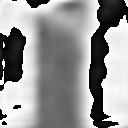

In [64]:
transforms.ToPILImage()(new_pred)

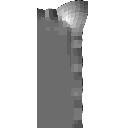

In [65]:
transforms.ToPILImage()(y)